In [3]:
#from tqdm import tqdm
from qiskit import quantum_info 
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
import pickle
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, DensityMatrix, Operator, partial_trace
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
basis_gates=['ecr', 'id', 'rz', 'sx', 'x']
#InteractiveShell.ast_node_interactivity = "all"
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="253c04c1782fbe76188d45069e8bb89a54c779e469a1e55417ad64306275238b8f7d6030db8b71b4292b2239a70d14290b4781376aeef8c98f239d8078a5e291",overwrite=True)
from scipy import sparse 

In [79]:
def Shat(A,T,G): 
    
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    Shatf = np.array([[1-t*tt,0,0,t+tt],[0,1+t*tt,t-tt,0],[0,-t+tt,1+t*tt,0],[-t-tt,0,0,1-t*tt]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (-1/np.sqrt(Nalpha))*Shat
    return Shat

def U(A,T,G):
    U = np.zeros((4,4), dtype=complex)
    
    U[0,0]=(-1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[0,3]=(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,1]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[1,2]=(-1+2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,1]=(-1-2*1j*A*(1/np.sinh(T))*np.sinh(G/2))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[2,2]=(1j*A*(1/np.sinh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,0]=-(1j*A*(1/np.cosh(T/2)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    U[3,3]=(1+2*1j*A*np.cosh(G/2)*(1/np.sinh(T)))/np.sqrt((1+2*A**(2)*(1/np.tanh(T))*(1/np.sinh(T)))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**2)
    
    return(U)

def Ureal(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)

def bwassembler_z(qc,matrix,layers,n):    #CHECKED#
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 

        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                qc.unitary(perm_nsite(matrix,n),[j for j in range(n)],label='ZZ')

            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        m+=1
    return(qc)

def bwassembler_z_prime(qc,matrix,layers,n):    #CHECKED#
    l=0
    while l<layers: 
        qc=bwassembler_z_even(qc,matrix,n)
        l+=1
        if l<layers:
            qc=bwassembler_z_odd(qc,matrix,n)
            l+=1
        else:
            break 
    return(qc)

def bwassembler_z_even(qc,matrix,n):    
    i=0;j=0;    
    #even layer
    while i < n/2:
        qc.unitary(matrix, [2*i,2*i+1])
        i+=1;
    qc.barrier(range(n)) 
    return(qc)
def bwassembler_z_odd(qc,matrix,n):    
    
    j=0;    
    while j < n/2:
        
        if j == (n/2 - 1):

            qc.unitary(perm_nsite(matrix,n),[j for j in range(n)],label='ZZ')
            qc.barrier(range(n))
            
        else:
            qc.unitary(matrix, [2*j+1,2*j+2])
        
        j+=1;
        
        
    
    
    return(qc)
def perm4site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12

def perm8site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(2**6))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2**5)))
    P34 = np.kron(np.eye(2**2),np.kron(P,np.eye(2**4)))
    P45 = np.kron(np.eye(2**3),np.kron(P,np.eye(2**3)))
    P56 = np.kron(np.eye(2**4),np.kron(P,np.eye(2**2)))
    P67 = np.kron(np.eye(2**5),np.kron(P,np.eye(2**1)))
    P78 = np.kron(np.eye(2**6),P)
    S78 = np.kron(np.eye(2**6),U)
    
    return P12@P23@P34@P45@P56@P67@P78@S78@P78@P67@P56@P45@P34@P23@P12       
    
def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator


def perm_nsite(U,n):   #CHECKED#
    if n < 2:
        raise ValueError("Number of sites (n) must be at least 2.")
    
    # Constructing a sparse array using ijv format
    # row  = np.array([0, 1, 2, 3])
    # col  = np.array([0, 2, 1, 3])
    # data = np.array([1, 1, 1, -1])
    #P=sparse.coo_array((data, (row, col)), shape=(4, 4)).toarray()

    # Define the permutation matrix P
    P = np.array([[1, 0, 0, 0],
                    [0, 0, 1, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, -1]])
    perm_list=[]
    # Construct permutation matrices and tensor products
    for i in range(0, n - 1):
        Pi = np.kron(np.eye(2 ** i), np.kron(P, np.eye(2 ** (n - i - 2))))
        perm_list.append(Pi)
        
    # Append U tensor product
    S_last = np.kron(np.eye(2 ** (n - 2)), U)
    perm_list.append(S_last)

    result = np.eye(2**n)
    #print(result, result.shape)
    for perm_matrix in perm_list:
        result = result @ perm_matrix

    perm_list.reverse()

    for perm_matrix in perm_list[1:]:
        result = result @ perm_matrix    
        
    return result

def combine_dicts(dict1, dict2):
    combined_dict = {}

    # Merge values from dict1 into combined_dict
    for key, subdict in dict1.items():
        combined_dict[key] = subdict.copy()

    # Merge values from dict2 into combined_dict
    for key, subdict in dict2.items():
        if key in combined_dict:
            # Merge subdicts for keys that exist in both dictionaries
            for subkey, value in subdict.items():
                combined_dict[key][subkey] = combined_dict[key].get(subkey, 0) + value
        else:
            # Add entire subdict for keys that don't exist in combined_dict
            combined_dict[key] = subdict.copy()

    return combined_dict

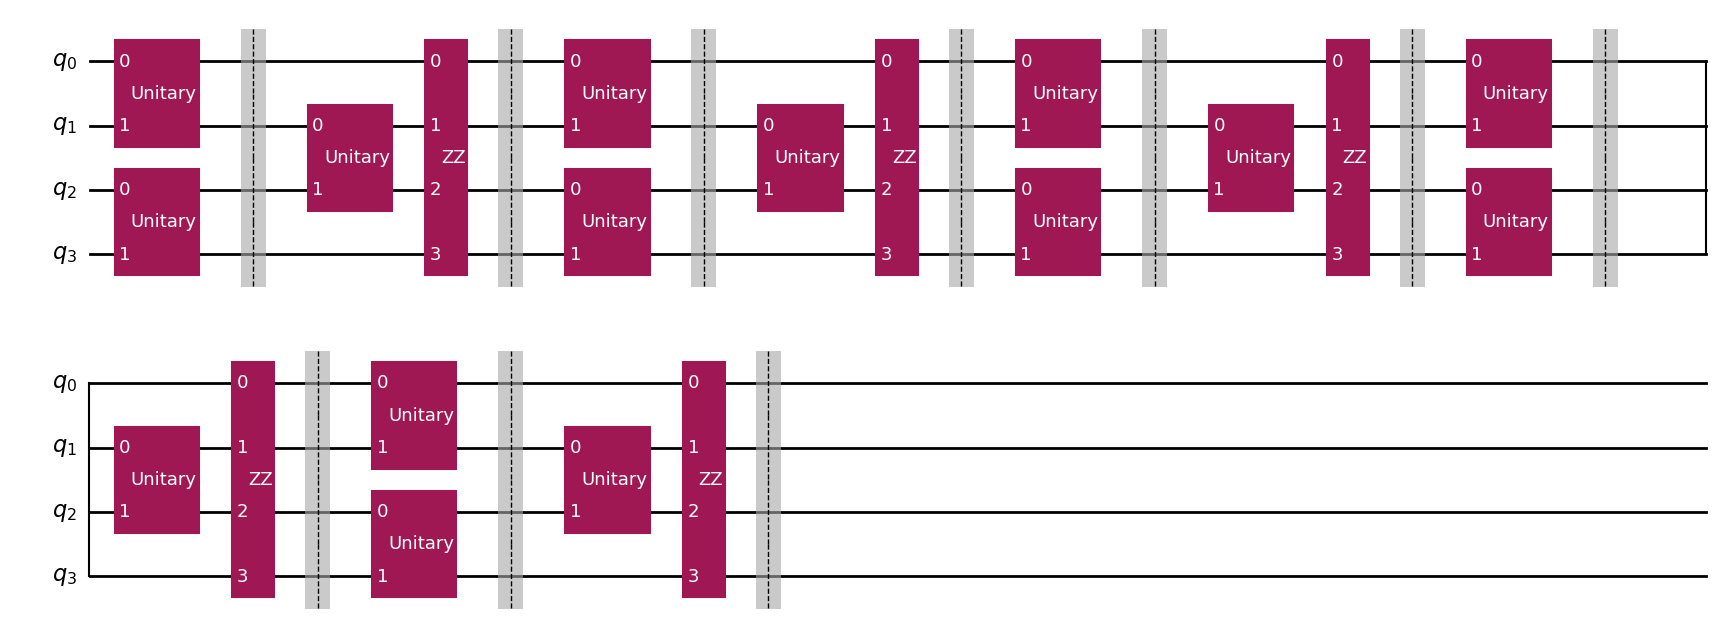

In [86]:
n=4
qc=QuantumCircuit(n)
qc = bwassembler_z_prime(qc,Shat(1,1,1),10,n)
qc.draw(output='mpl')



In [61]:
P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
np.allclose(P@Shat(1,1,1)@P,perm_nsite(Shat(1,1,1),2))

True

In [5]:
#check supercharges commutation on 4/8 sites
def x(t):
    return np.exp(t/4)
def y(g):
    return np.exp(g/4)
def Qplus4site(t,g):
    Ql12 = x(t)*y(g)*X(1,4)+(1/(x(t)*y(g)))*Z(1,4)@X(2,4)
    Ql34 = x(t)*y(g)*Z(1,4)@Z(2,4)@X(3,4)+(1/(x(t)*y(g)))*Z(1,4)@Z(2,4)@Z(3,4)@X(4,4)
    return Ql12+Ql34
def Qminus4site(t,g):
    Qr12 = (y(g)/x(g))*Y(1,4)+(x(t)/y(g))*Z(1,4)@Y(2,4)
    Qr34 = (y(g)/x(g))*Z(1,4)@Z(2,4)@Y(3,4)+(x(g)/y(g))*Z(1,4)@Z(2,4)@Z(3,4)@Y(4,4)
    return Qr12+Qr34
def Qplus8site(t,g):
    Ql12 = x(t)*y(g)*X(1,8)+(1/(x(t)*y(g)))*Z(1,8)@X(2,8)
    Ql34 = x(t)*y(g)*Z(1,8)@Z(2,8)@X(3,8)+(1/(x(t)*y(g)))*Z(1,8)@Z(2,8)@Z(3,8)@X(4,8)
    Ql56 = x(t)*y(g)*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@X(5,8)+(1/(x(t)*y(g)))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@X(6,8)
    Ql78 = x(t)*y(g)*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@Z(6,8)@X(7,8)+(1/(x(t)*y(g)))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@Z(6,8)@Z(7,8)@X(8,8)
    return Ql12+Ql34+Ql56+Ql78
def Qminus8site(t,g):
    Qr12 = (y(g)/x(t))*Y(1,8)+(x(t)/y(g))*Z(1,8)@Y(2,8)
    Qr34 = (y(g)/x(t))*Z(1,8)@Z(2,8)@Y(3,8)+(x(t)/y(g))*Z(1,8)@Z(2,8)@Z(3,8)@Y(4,8)
    Qr56 = (y(g)/x(t))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Y(5,8)+(x(t)/y(g))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@Y(6,8)
    Qr78 = (y(g)/x(t))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@Z(6,8)@Y(7,8)+(x(t)/y(g))*Z(1,8)@Z(2,8)@Z(3,8)@Z(4,8)@Z(5,8)@Z(6,8)@Z(7,8)@Y(8,8)
    return Qr12+Qr34+Qr56+Qr78

#Tensor Paulis on nth site given L sites ###checked###
def X(n,L):
    X = np.array([[0,1],[1,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(X,np.eye(2**(L-n)))))
def Y(n,L):
    Y = np.array([[0,-1j],[1j,0]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Y,np.eye(2**(L-n)))))    
def Z(n,L):
    Z = np.array([[1,0],[0,-1]])
    return (np.kron(np.eye(2**(n-1)),np.kron(Z,np.eye(2**(L-n)))))    

In [172]:
#COMMUTATIONS CHECK 
Qtot=Qminus4site(1,1)+Qplus4site(1,1)

qc = QuantumCircuit(4)
op=Operator(bwassembler_z(qc,Shat(1,1,1),1,4)).data
np.allclose(Qtot@op,op@Qtot)

#check locally on S12
t,g=1,-1
Ql12 = (x(t)*y(g))*X(1,2)+(1/(x(t)*y(g)))*Z(1,2)@X(2,2)
Qr12 = (y(g)/x(g))*Y(1,2)+(x(t)/y(g))*Z(1,2)@Y(2,2)
Qtot12 = Ql12+Qr12
S12 = Shat(1,t,g)
S21=P@Shat(1,t,g)@P
circ2site=S21@S12

In [171]:

print(
np.allclose(Qtot12@circ2site,circ2site@Qtot12),
np.allclose(Ql12@S12,S12@Ql12),
np.allclose(Ql12@S21,S21@Ql12),
np.allclose(Ql12@(S21@S12),(S21@S12)@Ql12),
np.allclose(Qr12@S12,S12@Qr12),
np.allclose(Qr12@S21,S21@Qr12),
np.allclose(Qr12@(S21@S12),(S21@S12)@Qr12)
)

True False False True True True True


In [4]:
#BIPARTITION, EE/RE


#Circuit parameters
n=4;A=0.15;G=0;

#Define arrays
 
thetas= np.arange(1e-10,10,0.05)
layers = [1]
sizes = np.array([8])
ent_entropy = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
renyi = np.zeros((len(sizes),len(layers),len(thetas)),dtype=complex)
eigvalsrho = np.zeros((len(sizes),len(layers),len(thetas),(2**(n//2))),dtype=complex)
counts = np.zeros((len(layers)))


for f,n in enumerate(sizes):
    
    subsystem = [j for j in range(0,n//2)]
    print(subsystem)
    
    for m,layer in enumerate(layers):
        
        #print(layer)
        
        for k,theta in enumerate(thetas):    
                
            string = "0" * (n)
            qc = QuantumCircuit(n)
            QuantumCircuit.initialize(qc,string)
            
            #init with Kareljan's state
            #qc.unitary(prodstaten(n), range(0,n))
    
            
            matrix = Ureal(A,theta,G)
            bwassembler_z(qc,matrix,layer,n)
            #qc = transpile(qc, basis_gates=basis_gates, optimization_level=3)
            
            
            #######################################################################    
            #access density matrix  
            rho = DensityMatrix(qc)
            
            reduced_rho=partial_trace(rho, subsystem)
            
            #find the eigenvalues of the reduced density matrix
            eigenvalues,_ = np.linalg.eig(reduced_rho)
           
            #compute the entanglement entropy
            
            order = eigenvalues.argsort()
            eigenvalues = eigenvalues[order]
            #eigvalsrho[f,m,k,:]= eigenvalues
            entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
            renyi[f,m,k]=-np.log(DensityMatrix.purity(reduced_rho))
            ent_entropy[f,m,k]=entanglement_entropy
            #print(k,ent_entropy[k])
            ######################################################################
    print(qc.count_ops())

[0, 1, 2, 3]


NameError: name 'Ureal' is not defined

amplitude of bw eigenstates per theta plot


we are apparently generating equal superpositions of bell pairs 

arg(allzerostate) winds as many times as dips in the abs(allzerostate), telling how many oscillations we will see in EE spectrum 

0011 and 1100 

0110 and 1001


large and small alpha limits and point out buildup is given by 4 states dominating dynamics 

equation showing 4 states dominate dynamics 



One can compute Renyi entropies for quenches from the all zero initial state under the evolution dictated by UBW. The unitary can be applied n times per theta, and one can observe how the associated renyi entropy will exhibit n maxima. By direct inspection one can notice that this dynamical behaviour is ruled by only 4 states. Following the arrow of time from the start of the quench, one notices that the amplitude 0000, which is initially set to one, dips n times, and every dip is associated to an increase in the (equal) amplitudes of pairs (0011,1100) and (0110,1001). The fact that this states exhibit different behaviour under PBC can be understood by the lack of translational symmetry dictated by the odd-even layer staggering.

/home/alberto/anaconda3/envs/qusim2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alberto/anaconda3/envs/qusim2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


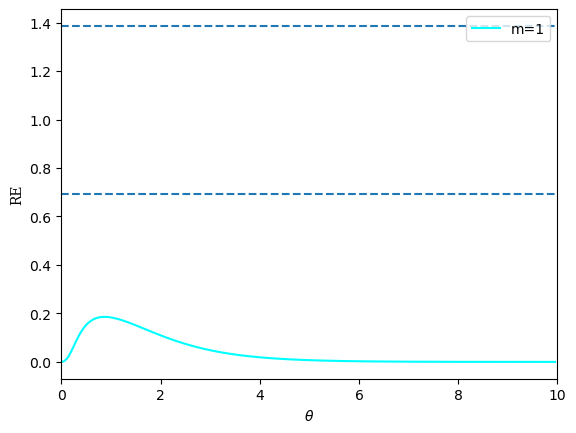

In [305]:
csfont = {'fontname':'Serif'}
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(sizes))))
leng= np.array([2,3,4],dtype=int)

for j,size in enumerate(layers):
    color1 = next(color_cycle1)
    #plt.plot(thetas,ent_entropy[j,0],'-', c=color1,label='EE N='+str(size))
    color2 = next(color_cycle2)
    plt.plot(thetas,renyi[0,j],'-', c=color1,label='m='+str(size))
    
#plt.plot(thetas,eigvalsrho[0,0,:],'-.')


#plt.title('PBC, A= '+str(A)+' G='+str(G)+' init 0',**csfont)
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$', **csfont)
plt.ylabel('RE', **csfont)
plt.xlim(0,10)
#plt.ylim(0,1.5)
plt.legend(loc='upper right')   
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/PBC diff layers a=0.15 g=0.pdf", bbox_inches='tight')  

In [10]:
#BIPARTITION, varying layers per datapoint - ZZ update


#Circuit parameters
n=4;A=1;G=1;

#Define arrays
 
thetas= np.arange(1e-5,20,0.1)
layers = [1,2,5]
ent_entropy = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [j for j in range(0,n//2)]
print(subsystem)

for m,layer in enumerate(layers):
    print(layer)
    for k,theta in tqdm(enumerate(thetas)):    
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        #QuantumCircuit.initialize(qc,string)
        
        #init with Kareljan's state
        qc.unitary(prodstaten(n), range(0,n))

        #print('theta=',T)
        #print('layers=',layer)
        #matrix = U(A,theta,G)
        #try other matrix
        matrix = U(A,theta,G)
        bwassembler_z(qc,matrix,layer,n)
        #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       #
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

[0, 1]
1


NameError: name 'tqdm' is not defined

In [7]:
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
aer_sim=AerSimulator()
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
string = "00000000011000000000" 
len(string)

20

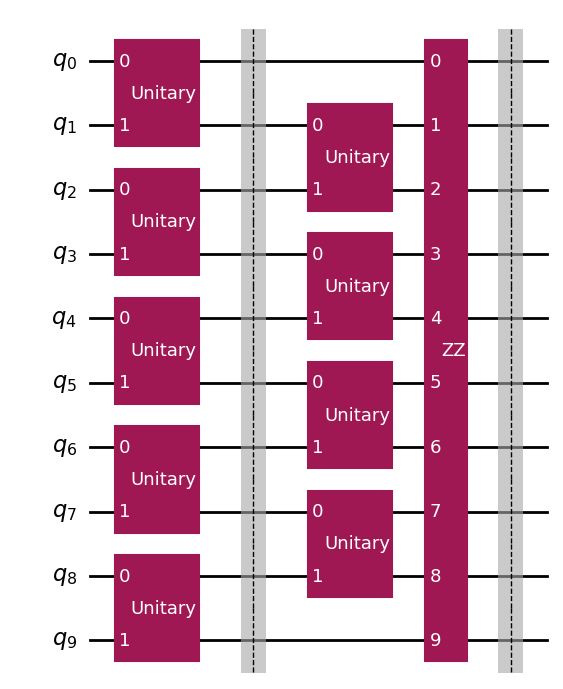

In [15]:
n=10
qc = QuantumCircuit(n)
matrix = Ureal(A,T,G)
bwassembler_z(qc,matrix,l,n)
qc.draw(output='mpl')

In [33]:
#densities 8 sites PBC
n=8;A=1;G=0.693147;T=0.1;layers=10
shots=1000
layers = [j for j in range(1,layers)]
occupations_dict = {}


for _,l in enumerate(layers): 

    string = "00011000" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    matrix = Shat(A,T,G)
    bwassembler_z(qc,matrix,l,n)
    qc.measure_all()
    #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

    #print('a')
    ######EXECUTION########

    backend = aer_sim
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(qc)
    #print('b')
    with Session(backend=aer_sim) as session:
        sampler = Sampler(session=session)
        result = sampler.run([isa_qc], shots=shots).result()

    # Get the results
    print(l)
    #print(l,result[0].data.meas.get_counts())
    counts = result[0].data.meas.get_counts()
    #print(len(counts))
    #print('layer',l)
    occupations_dict[f'occupations_{l}']=counts
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       
    



/home/alberto/anaconda3/envs/qusim2/lib/python3.12/site-packages/qiskit_ibm_runtime/session.py:156: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


1
2
3
4
5
6
7
8
9


In [163]:
#densities 8 sites PBC single layer step
n=8;A=1;G=0.336472;T=0.1;layers=20   #G=1.09861 means m1/m3=3 which according to v_d=m1+m2/m1-m2 means vd=2; 0.510826 for vd=4; 0.336472 for vd=6
shots=1000
layers = [j for j in range(1,layers)]
occupations_dict = {}


for _,l in enumerate(layers): 

    string = "00011000" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    matrix = Shat(A,T,G)
    bwassembler_z_prime(qc,matrix,l,n)
    qc.measure_all()
    #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

    #print('a')
    ######EXECUTION########

    backend = aer_sim
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(qc)
    #print('b')
    with Session(backend=aer_sim) as session:
        sampler = Sampler(session=session)
        result = sampler.run([isa_qc], shots=shots).result()

    # Get the results
    print(l)
    #print(l,result[0].data.meas.get_counts())
    counts = result[0].data.meas.get_counts()
    #print(len(counts))
    #print('layer',l)
    occupations_dict[f'occupations_{l}']=counts
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       
    



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


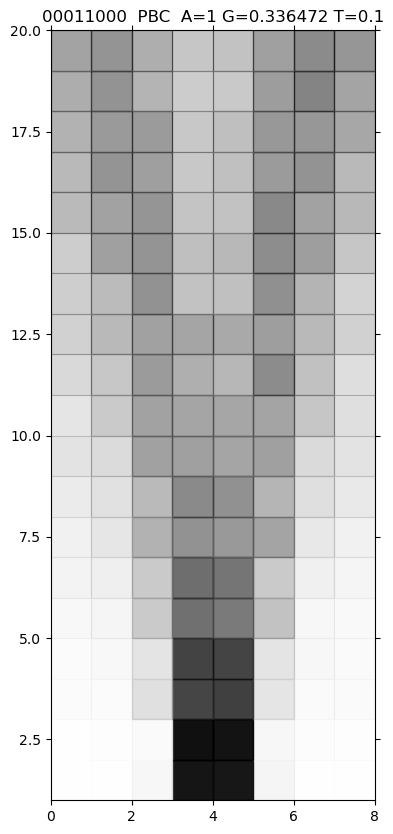

In [164]:
# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))


# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set limits for the x-axis
ax.set_xlim(0, n)
ax.set_ylim(1, len(occupations_dict.keys())+1)

for h,vals in enumerate(occupations_dict.values()):
    #set max value of opacity
    max_val=max(vals.values())
    max_val=max_val/shots
    #print(max_val)
    # Loop through the dictionary items and plot the squares
    for i, (binary, value) in enumerate(vals.items()):
        for j in range(n):
            x = n-j-1  # x-coordinate
            y = i  # y-coordinate
            
            # Determine color based on binary value
            color = 'black' if binary[j] == '1' else 'white'
            
            # Determine opacity based on value
            opacity = (value/shots)#/max_val
            
            # Draw the square
            ax.add_patch(plt.Rectangle((x, h+1), 1, 1, color=color, alpha=opacity))

# Hide the axes
#ax.axis('off')
# Show the ticks on both axes
plt.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True)


plt.title(string+'  PBC  A='+str(A)+' G='+str(G)+' T='+str(T))
# Show the plot
plt.show()

Next step: 
We propagate from initial 1 and all others zero both from an even site and then from an odd one, so we get the two light cone behaviours (ev: 10000000, od: 01000000). We make many shots for both and generate the two respective arrays without normalization, then we sum them element by element, renormalize every row according to the biggest number in the row and then plot that 

In [268]:
#DRIFT ev vs odd 8 sites PBC
n=8;A=1;G=0.693147;T=0.1;layers=26
shots=1000
#15 min for 10000 shots, 30 layers
layers = [j for j in range(1,layers)]
occupations_dict_ev = {}
occupations_dict_od = {}

###EVEN###
for _,l in enumerate(layers): 

    string = "00001000" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    matrix = Ureal(A,T,G)
    bwassembler_z(qc,matrix,l,n)
    qc.measure_all()
  
    ######EXECUTION########
    backend = aer_sim
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(qc)
    #print('b')
    with Session(backend=aer_sim) as session:
        sampler = Sampler(session=session)
        result = sampler.run([isa_qc], shots=shots).result()

    # Get the results
    #print('c')
    #print(l,result[0].data.meas.get_counts())
    counts = result[0].data.meas.get_counts()
    #print(len(counts))
    #print('layer',l)
    occupations_dict_ev[f'occupations_{l}']=counts
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       

print('###############################')

###ODD###
for _,l in enumerate(layers): 

    string = "00010000" 
    qc = QuantumCircuit(n)
    QuantumCircuit.initialize(qc,string)
    matrix = Ureal(A,T,G)
    bwassembler_z(qc,matrix,l,n)
    qc.measure_all()

    ######EXECUTION#######
    backend = aer_sim
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
    isa_qc = pm.run(qc)
    #print('b')
    with Session(backend=aer_sim) as session:
        sampler = Sampler(session=session)
        result = sampler.run([isa_qc], shots=shots).result()

    # Get the results
    #print('c')
    #print(l,result[0].data.meas.get_counts())
    counts = result[0].data.meas.get_counts()
    #print(len(counts))
    #print('layer',l)
    occupations_dict_od[f'occupations_{l}']=counts
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')       
test={}
combined_occ=combine_dicts(occupations_dict_od,occupations_dict_ev)
print(combined_occ)

###############################
{'occupations_1': {'00010000': 874, '01000000': 17, '00001000': 864, '00100000': 100, '00010110': 3, '00101100': 1, '00011100': 2, '11010000': 3, '10001010': 1, '00010011': 4, '00001011': 3, '01101000': 1, '00000100': 104, '00000010': 15, '00111000': 3, '11001000': 2, '00001110': 1, '10000101': 1, '11000100': 1}, 'occupations_2': {'00001000': 596, '01000000': 89, '00010000': 579, '00100000': 263, '00010110': 11, '00011100': 7, '00100101': 1, '10010001': 5, '00001011': 8, '01101000': 8, '00100110': 2, '01000110': 3, '10100001': 3, '11001000': 8, '00000010': 76, '01011000': 1, '00001110': 6, '00011010': 3, '00000100': 281, '11010000': 3, '10001001': 3, '01110000': 3, '00101100': 1, '01100001': 1, '11000001': 2, '10000101': 3, '00010011': 3, '11100000': 2, '10000000': 2, '00101010': 1, '00000111': 5, '00111000': 8, '00110010': 1, '11000100': 3, '11000010': 1, '10101000': 1, '01100100': 2, '10000011': 1, '00000001': 1, '00110100': 2, '01010100': 1}, 'occupat

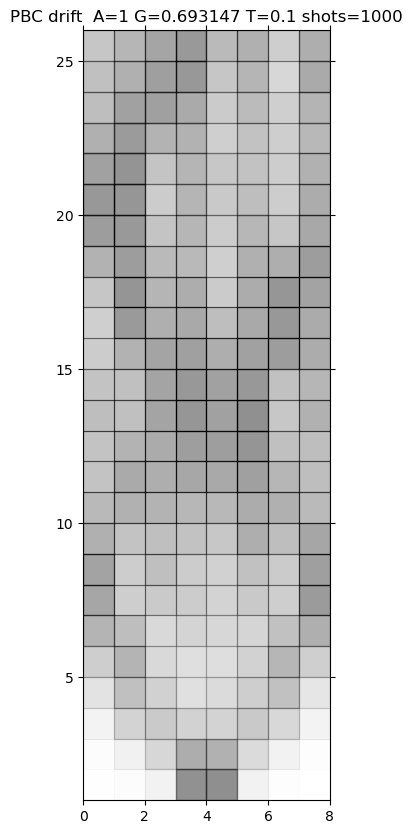

In [269]:
#COMBINED EVEN ODD PLOT 
# Define the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))


# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set limits for the x-axis
ax.set_xlim(0, n)
ax.set_ylim(1, len(combined_occ.keys())+1)

for h,vals in enumerate(combined_occ.values()):
    #set max value of opacity
    max_val=max(vals.values())

    max_val=max_val/(shots)
    
    #print(max_val)
    # Loop through the dictionary items and plot the squares
    sumcheck=0
    for i, (binary, value) in enumerate(vals.items()):
        #print('current binary: ',binary,'string P: ',value/(2*shots))   
        opacity=np.zeros(n)
        for j in range(n):
            opacity[j] = (value*int(binary[j])/(2*shots))
            x = n-j-1  # x-coordinate
            #y = i  # y-coordinate
            
            # Determine color based on binary value
            color = 'black' if binary[j] == '1' else 'white'
            
            # Determine opacity based on value
            
            
            
            #print(binary,j,opacity)
            # Draw the square
            ax.add_patch(plt.Rectangle((x, h+1), 1, 1, color=color, alpha=opacity[j]))

        
        sumcheck=sumcheck+(value/(2*shots))
        #print('i=',i,'sumcheck=',sumcheck)
    #print('Total prob per line ',sumcheck)

plt.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True)
plt.title('PBC drift  A='+str(A)+' G='+str(G)+' T='+str(T)+' shots='+str(shots))
# Show the plot
plt.show()